# <center><span style="color:black"> HR Analytics: Make Switch or Not </span></center>

#### Features

* enrollee_id : Unique ID for candidate
* city: City code
* city_ development _index : Developement index of the city (scaled)
* gender: Gender of candidate
* relevent_experience: Relevant experience of candidate
* enrolled_university: Type of University course enrolled if any
* education_level: Education level of candidate
* major_discipline :Education major discipline of candidate
* experience: Candidate total experience in years
* company_size: No of employees in current employer's company
* company_type : Type of current employer
* lastnewjob: Difference in years between previous job and current job
* training_hours: training hours completed
* target: 0 – Not looking for job change, 1 – Looking for a job change

#### Loading all required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import KNNImputer
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score,precision_score, recall_score,confusion_matrix, plot_roc_curve, auc, precision_recall_curve
from sklearn.model_selection import GridSearchCV
sns.set()
%matplotlib inline

#### Lodaing data and basic exploration

In [2]:
# Load the data
data= pd.read_csv("data.csv")
df=data.copy()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

In [4]:
# check rows and columns
df.shape

(19158, 14)

In [5]:
# Display the top 5 rows.
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [6]:
# Find the data types of columns
df.dtypes

enrollee_id                 int64
city                       object
city_development_index    float64
gender                     object
relevent_experience        object
enrolled_university        object
education_level            object
major_discipline           object
experience                 object
company_size               object
company_type               object
last_new_job               object
training_hours              int64
target                    float64
dtype: object

In [7]:
df.isnull().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64

Data contains a lot of null values, we will later decide whether we can fill these null values or drop them.

In [8]:
df.describe()

,enrollee_id,city_development_index,training_hours,target
count,19158.000000,19158.000000,19158.000000,19158.000000
mean,16875.358179,0.828848,65.366896,0.249348
std,9616.292592,0.123362,60.058462,0.432647
min,1.000000,0.448000,1.000000,0.000000
25%,8554.250000,0.740000,23.000000,0.000000
50%,16982.500000,0.903000,47.000000,0.000000
75%,25169.750000,0.920000,88.000000,0.000000
max,33380.000000,0.949000,336.000000,1.000000


In [9]:
df.describe(include='O')

,city,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job
count,19158,14650,19158,18772,18698,16345,19093,13220,13018,18735
unique,123,3,2,3,5,6,22,8,6,6
top,city_103,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,1
freq,4355,13221,13792,13817,11598,14492,3286,3083,9817,8040


In [10]:
df.target.value_counts()

0.0    14381
1.0     4777
Name: target, dtype: int64

The above figures show a clear case of class imbalance where no. of positive class is way less than neative class

### EDA

##### city_development_index

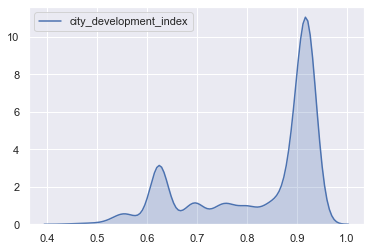

In [11]:
sns.kdeplot(df['city_development_index'], shade=True);

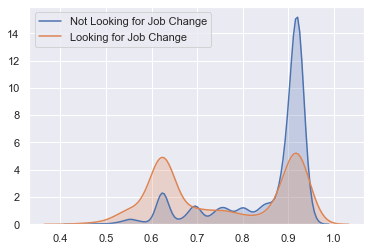

In [12]:
sns.kdeplot(df[df['target'] == 0]['city_development_index'], shade=True,label="Not Looking for Job Change");
sns.kdeplot(df[df['target'] == 1]['city_development_index'], shade=True,label="Looking for Job Change");

Although, there are two separate peaks for employees looking for a job switch, but one giant peak for employess not looking for a job switch indicates that people belonging to developed cities are not that mcuh interested in a switch.

##### gender

In [13]:
df['gender'].isnull().sum()

4508

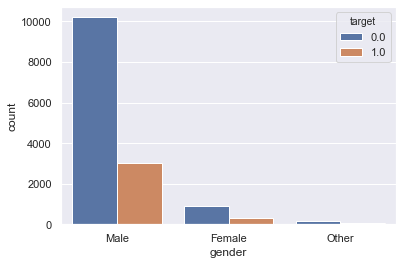

In [14]:
sns.countplot(x='gender', hue='target', data =df)
plt.show()

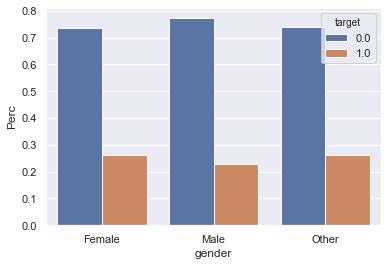

In [15]:
temp = df.groupby('gender')['target'].value_counts(normalize=True).reset_index(name='Perc')

sns.barplot(x='gender', y='Perc', hue='target', data=temp, dodge=True);

As per above plot, same percent of employees are looking for a switch irrespective of the gender, however, there are al ot of males so, this feature could help in predicting target variable.

##### relevent_experience

In [16]:
df['relevent_experience'].isnull().sum()

0

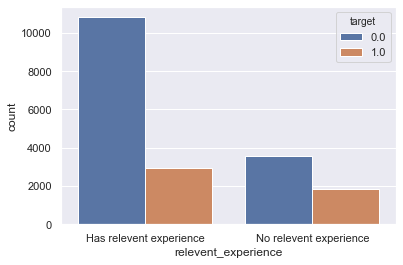

In [17]:
sns.countplot(x='relevent_experience', hue='target', data =df)
plt.show()

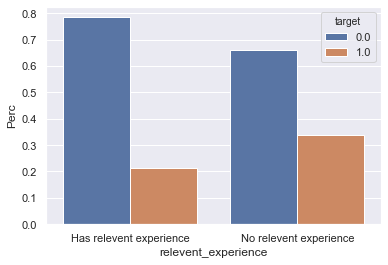

In [18]:
temp = df.groupby('relevent_experience')['target'].value_counts(normalize=True).reset_index(name='Perc')

sns.barplot(x='relevent_experience', y='Perc', hue='target', data=temp, dodge=True);

Almost 35% of Employess with no relevant expereience switched jobs.

##### enrolled_university

In [19]:
df['enrolled_university'].isnull().sum()

386

In [20]:
df['enrolled_university'].fillna(value=df['enrolled_university'].mode().values[0], inplace=True)

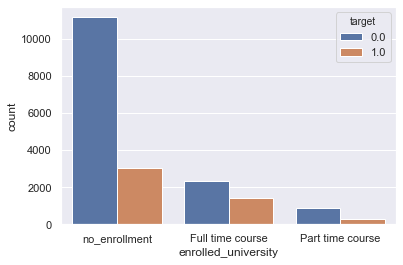

In [21]:
sns.countplot(x='enrolled_university', hue='target', data =df)
plt.show()

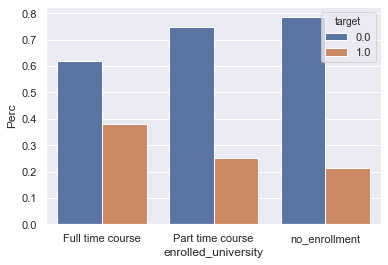

In [22]:
temp = df.groupby('enrolled_university')['target'].value_counts(normalize=True).reset_index(name='Perc')

sns.barplot(x='enrolled_university', y='Perc', hue='target', data=temp, dodge=True);

##### education_level

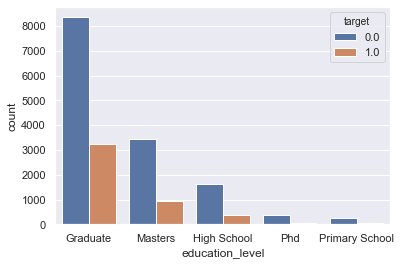

In [23]:
sns.countplot(x='education_level', hue='target', data =df)
plt.show()

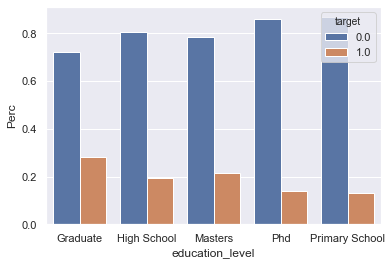

In [24]:
temp = df.groupby('education_level')['target'].value_counts(normalize=True).reset_index(name='Perc')

sns.barplot(x='education_level', y='Perc', hue='target', data=temp, dodge=True);

Graduates tend to switch more as compared to others. To simplify things we can define 3 groups here, UnderGrads, Graduate and PostGrads

In [25]:
df.loc[(df['education_level']=='High School')|(df['education_level']=='Primary School'),'education_level' ]='UnderGrad'
df.loc[(df['education_level']=='Phd')|(df['education_level']=='Masters'),'education_level' ]='PostGrad'

In [26]:
df['education_level'].unique()

array(['Graduate', 'PostGrad', 'UnderGrad', nan], dtype=object)

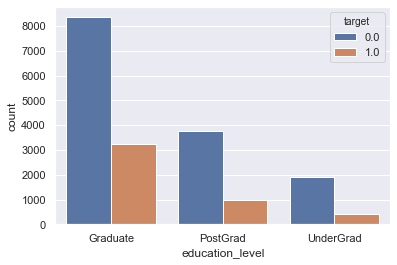

In [27]:
sns.countplot(x='education_level', hue='target', data =df)
plt.show()

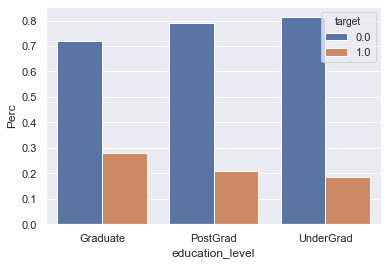

In [28]:
temp = df.groupby('education_level')['target'].value_counts(normalize=True).reset_index(name='Perc')

sns.barplot(x='education_level', y='Perc', hue='target', data=temp, dodge=True);

##### major_discipline

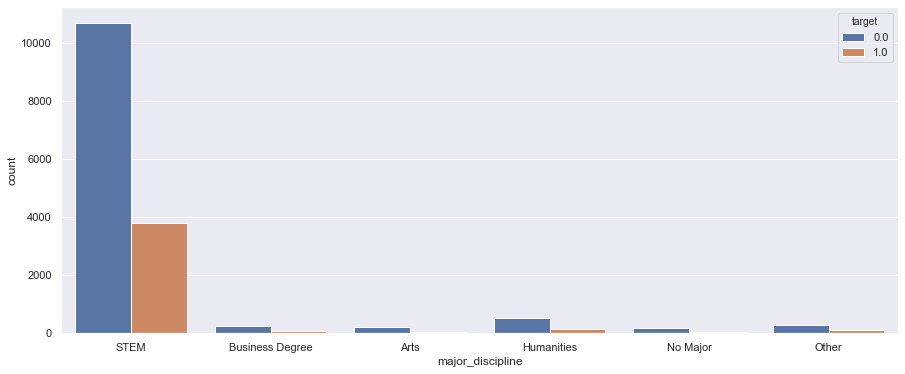

In [29]:
plt.figure(figsize=(15,6))
sns.countplot(x='major_discipline', hue='target', data =df)
plt.show()

It is clear that the prevailing value is 'STEM'. It means that most people have a technical education like engineering, math etc. So, let's create 2 groups to make the dataset more balanced: 'STEM' and 'Not STEM', which contains all other groups.

In [30]:
df.loc[(df['major_discipline']!='STEM'),'major_discipline' ]='Non-STEM'

In [31]:
df['major_discipline'].unique()

array(['STEM', 'Non-STEM'], dtype=object)

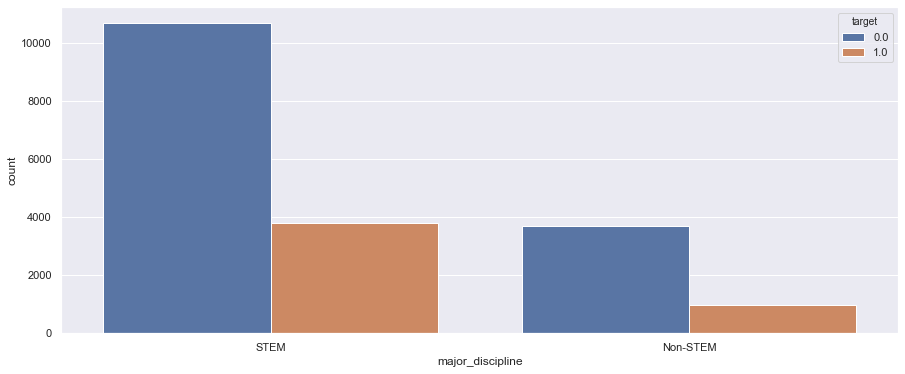

In [32]:
plt.figure(figsize=(15,6))
sns.countplot(x='major_discipline', hue='target', data =df)
plt.show()

This covers the null values as well

##### experience

In [33]:
df['experience'].unique()

array(['>20', '15', '5', '<1', '11', '13', '7', '17', '2', '16', '1', '4',
       '10', '14', '18', '19', '12', '3', '6', '9', '8', '20', nan],
      dtype=object)

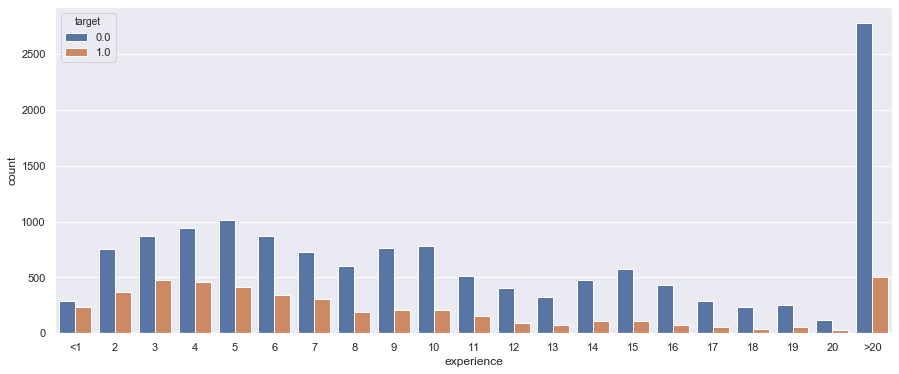

In [34]:
plt.figure(figsize=(15,6))
sns.countplot(x='experience', order=['<1','2','3','4', '5', '6','7','8','9','10', '11','12','13','14','15','16','17','18','19','20','>20'],hue='target', data =df)
plt.show()

'>20' and '<1' can be cosidered as 21 and 0 respectively.

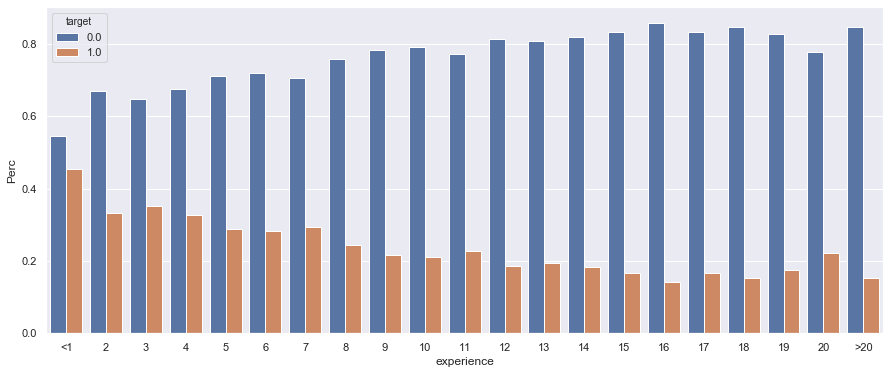

In [36]:
temp = df.groupby('experience')['target'].value_counts(normalize=True).reset_index(name='Perc')
plt.figure(figsize=(15,6))

sns.barplot(x='experience', y='Perc',order=['<1','2','3','4', '5', '6','7','8','9','10', '11','12','13','14','15','16','17','18','19','20','>20'], hue='target', data=temp, dodge=True);

In [37]:
df.loc[(df['experience']=='>20'),'experience' ]='21'
df.loc[(df['experience']=='<1'),'experience' ]='0'

##### company_size

In [38]:
df['company_size'].unique()

array([nan, '50-99', '<10', '10000+', '5000-9999', '1000-4999', '10/49',
       '100-500', '500-999'], dtype=object)

In [39]:
df['company_size'] = df['company_size'].str.replace("/",'-')

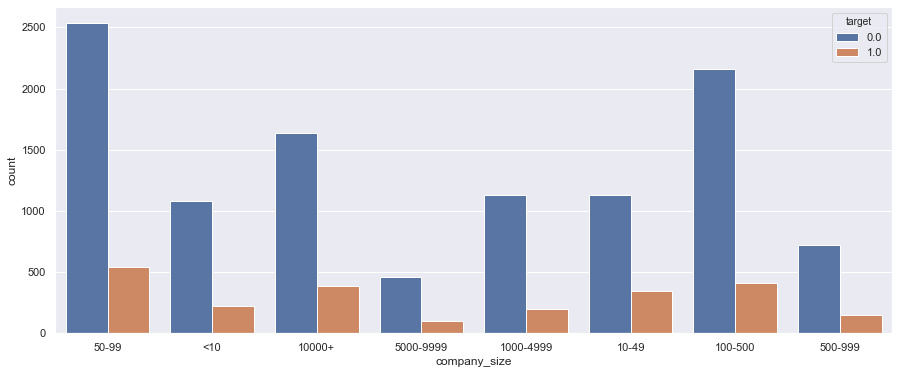

In [40]:
plt.figure(figsize=(15,6))
sns.countplot(x='company_size', hue='target', data =df)
plt.show()

10/49 seems like an error and should be 10-49. 

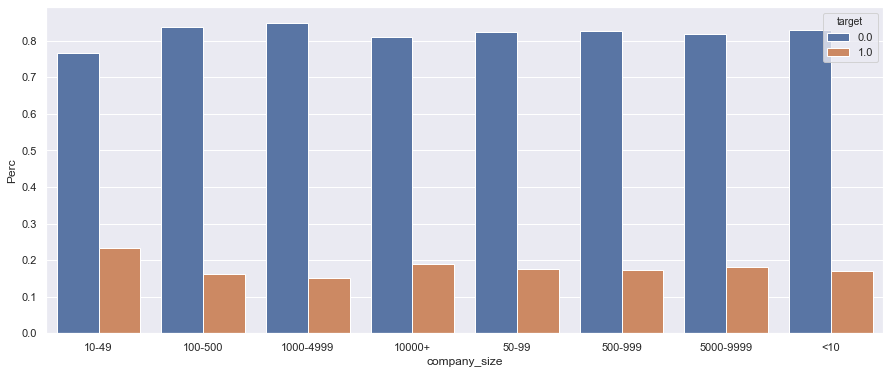

In [41]:
temp = df.groupby('company_size')['target'].value_counts(normalize=True).reset_index(name='Perc')
plt.figure(figsize=(15,6))
sns.barplot(x='company_size', y='Perc', hue='target', data=temp, dodge=True);

ratio of employees make a job switch seem a bit higher where company size is 10-49, Furthermore, we can simplify the data by categorizing the size of company

    - Microentreprises: 1 to 9 employees.
    - Small enterprises: 10 to 49 employees.
    - Medium-sized enterprises: 50 to 500 employees.
    - Large enterprises: 501 employees or more.

In [46]:
df.loc[(df['company_size']=='<10'),'company_size' ]='Microentreprises'
df.loc[(df['company_size']=='10-49'),'company_size' ]='Small enterprises'
df.loc[(df['company_size']=='50-99')|(df['company_size']=='100-500'),'company_size' ]='Medium-sized enterprises'
df.loc[(df['company_size']=='500-999')|(df['company_size']=='1000-4999')|(df['company_size']=='5000-9999')|(df['company_size']=='10000+'),'company_size' ]='Large enterprises'

In [47]:
df['company_size'].unique()

array([nan, 'Medium-sized enterprises', 'Microentreprises',
       'Large enterprises', 'Small enterprises'], dtype=object)

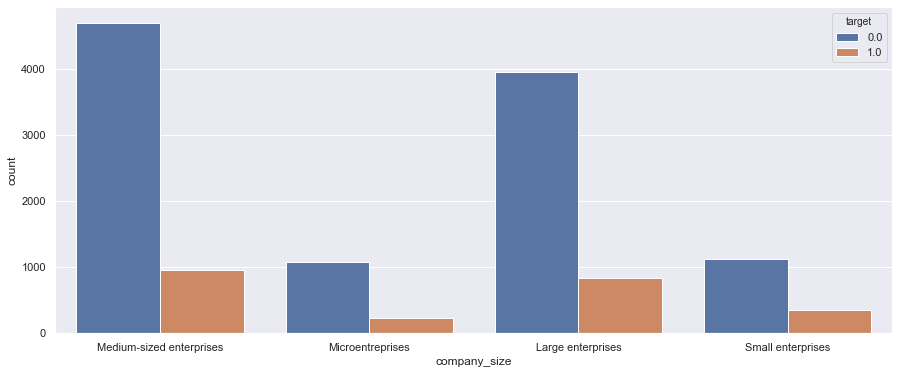

In [48]:
plt.figure(figsize=(15,6))
sns.countplot(x='company_size', hue='target', data =df)
plt.show()

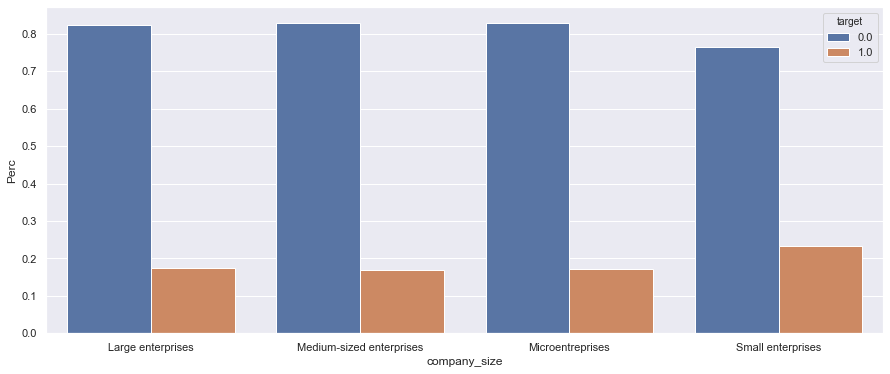

In [49]:
temp = df.groupby('company_size')['target'].value_counts(normalize=True).reset_index(name='Perc')
plt.figure(figsize=(15,6))
sns.barplot(x='company_size', y='Perc', hue='target', data=temp, dodge=True);

##### company_type

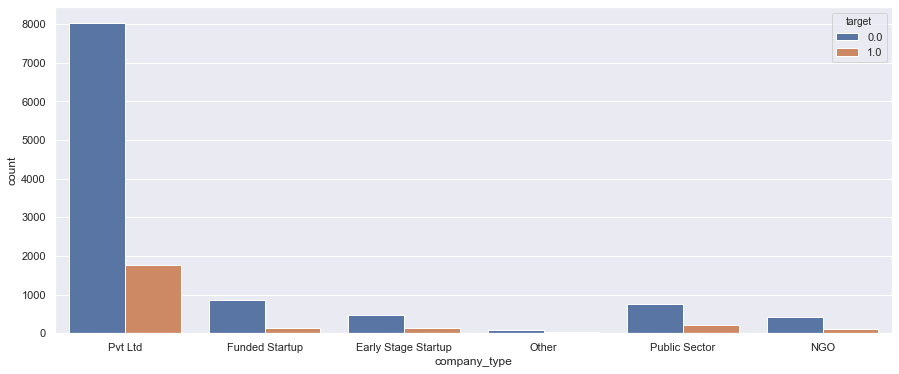

In [50]:
plt.figure(figsize=(15,6))
sns.countplot(x='company_type', hue='target', data =df)
plt.show()

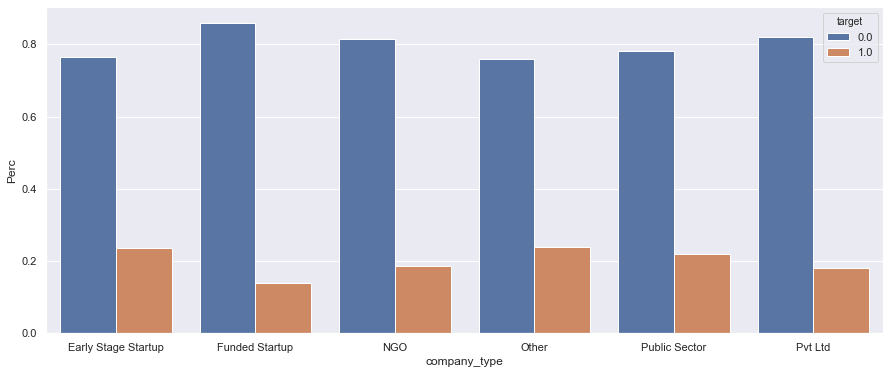

In [51]:
temp = df.groupby('company_type')['target'].value_counts(normalize=True).reset_index(name='Perc')
plt.figure(figsize=(15,6))
sns.barplot(x='company_type', y='Perc', hue='target', data=temp, dodge=True);

A lot of people in given data work for public sector companies, but ratio of employess make a job switch is higher in Early stage starups and Other

##### last_new_job

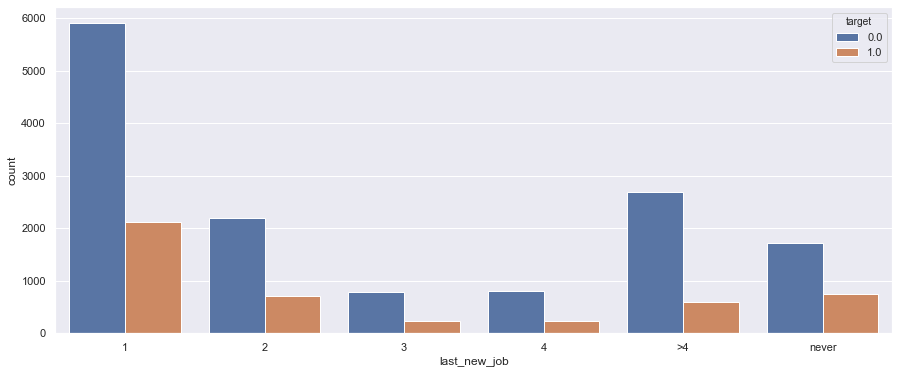

In [56]:
plt.figure(figsize=(15,6))
sns.countplot(x='last_new_job', order=['1','2','3','4','>4', 'never'],hue='target', data =df)
plt.show()

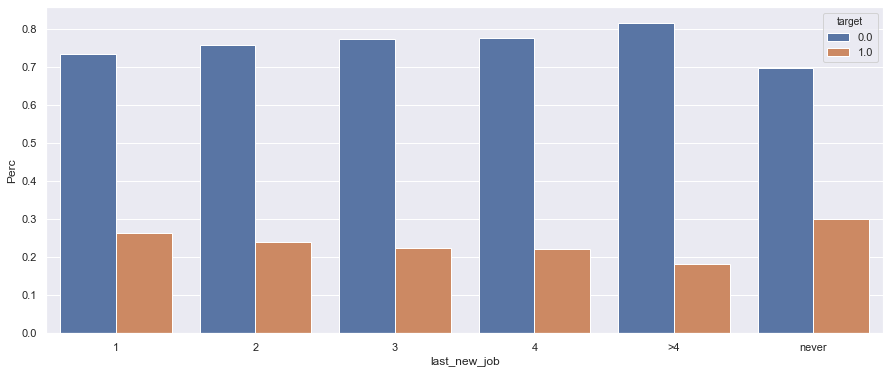

In [57]:
temp = df.groupby('last_new_job')['target'].value_counts(normalize=True).reset_index(name='Perc')
plt.figure(figsize=(15,6))
sns.barplot(x='last_new_job', y='Perc',order=['1','2','3','4','>4','never'], hue='target', data=temp, dodge=True);

this shows that people who have never made a job switch or are at there first jobs are more likely to go for a job switch, while people who have spend more than 4 years at there current company are less likely to go for the switch.

##### training_hours

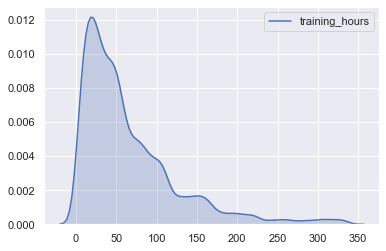

In [58]:
sns.kdeplot(df['training_hours'], shade=True);

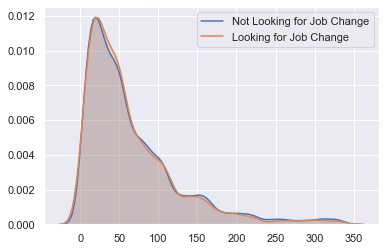

In [46]:
sns.kdeplot(df[df['target'] == 0]['training_hours'], shade=True,label="Not Looking for Job Change");
sns.kdeplot(df[df['target'] == 1]['training_hours'], shade=True,label="Looking for Job Change");

Distribution of training hrs is right skewed and for both type of targets is exactly the same with some outliers as well

### Converting the Categorical Variables to numerical

In [48]:
lb_en = LabelEncoder()
df.loc[:,'city'] = lb_en.fit_transform(df.loc[:,'city']) 

For the rest of varaibles we can transform them using a maaping dictionary to keep track of the transformd lables

In [49]:
gender = {
        'Female': 2,
        'Male': 1,
        'Other': 0
         }

relevent_experience = {
    'Has relevent experience':1,
    'No relevent experience':0
}

enrolled_university = {
    'no_enrollment':0,
    'Full time course':1, 
    'Part time course':2 
}
    
education_level = {
    'UnderGrad':0,
    'Graduate':1,
    'PostGrad':2
    } 
    
major ={ 
    'STEM':0,
    'Non-STEM':1, 
    }
    
experience = {
    '0':0,
    '1':1, 
    '2':2, 
    '3':3, 
    '4':4, 
    '5':5,
    '6':6,
    '7':7,
    '8':8, 
    '9':9, 
    '10':10, 
    '11':11,
    '12':12,
    '13':13, 
    '14':14, 
    '15':15, 
    '16':16,
    '17':17,
    '18':18,
    '19':19, 
    '20':20, 
    '21':21
} 
    
company_type = {
    'Pvt Ltd' :0,
    'Funded Startup':1, 
    'Early Stage Startup':2, 
    'Other':3, 
    'Public Sector':4, 
    'NGO':5
}

company_size = {
    'Microentreprises':0,
    'Small enterprises':1,
    'Medium-sized enterprises':2,
    'Large enterprises':3
}
    
last_new_job = {
    'never':0,
    '1':1, 
    '2':2, 
    '3':3, 
    '4':4, 
    '>4':5
}

In [50]:
df.loc[:,'education_level'] = df['education_level'].map(education_level)
df.loc[:,'company_size'] = df['company_size'].map(company_size)
df.loc[:,'company_type'] = df['company_type'].map(company_type)
df.loc[:,'last_new_job'] = df['last_new_job'].map(last_new_job)
df.loc[:,'major_discipline'] = df['major_discipline'].map(major)
df.loc[:,'enrolled_university'] = df['enrolled_university'].map(enrolled_university)
df.loc[:,'relevent_experience'] = df['relevent_experience'].map(relevent_experience)
df.loc[:,'gender'] = df['gender'].map(gender)
df.loc[:,'experience'] = df['experience'].map(experience)

### Handling Missing Values

There are various ways to handle missing values. One way is to drop those columns that have significant amount of missing values in them.
But here let's use ML techniques to fil out missing values and see how well it pans out.
For the current data we will use KNN Imputer to fill out missing values.

To fill out missing data we need only those columns that have missing values in them and for this purpose we will form two separate dataframes, one with columns that have missing values in them and other with columns that don

In [51]:
# missing columns
missing_cols = df.columns[df.isna().any()].tolist()
missing_cols

['gender',
 'education_level',
 'experience',
 'company_size',
 'company_type',
 'last_new_job']

In [52]:
df

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,5,0.920,1.0,1,0,1.0,0,21.0,NaN,NaN,1.0,36,1.0
1,29725,77,0.776,1.0,0,0,1.0,0,15.0,2.0,0.0,5.0,47,0.0
2,11561,64,0.624,NaN,0,1,1.0,0,5.0,NaN,NaN,0.0,83,0.0
3,33241,14,0.789,NaN,0,0,1.0,1,0.0,NaN,0.0,0.0,52,1.0
4,666,50,0.767,1.0,1,0,2.0,0,21.0,2.0,1.0,4.0,8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19153,7386,55,0.878,1.0,0,0,1.0,1,14.0,NaN,NaN,1.0,42,1.0
19154,31398,5,0.920,1.0,1,0,1.0,0,14.0,NaN,NaN,4.0,52,1.0
19155,24576,5,0.920,1.0,1,0,1.0,0,21.0,2.0,0.0,4.0,44,0.0
19156,5756,94,0.802,1.0,1,0,0.0,1,0.0,3.0,0.0,2.0,97,0.0


In [53]:
#dataframe having features with missing values
df_missing = df[['enrollee_id','gender','education_level','experience','company_size','company_type', 'last_new_job']]

In [54]:
#dataframe having features without missing values
df_non_missing = df.drop(missing_cols, axis = 1)

In [55]:
#k-Nearest Neighbour Imputation
knn_imputer = KNNImputer(n_neighbors = 3)
X = np.round(knn_imputer.fit_transform(df_missing))

In [56]:
X.shape

(19158, 7)

In [57]:
df_missing = pd.DataFrame(X, columns = df_missing.columns)
df2 = pd.merge(df_missing, df_non_missing, on = 'enrollee_id')

In [58]:
df=df2.copy()

In [59]:
df.isnull().sum()

enrollee_id               0
gender                    0
education_level           0
experience                0
company_size              0
company_type              0
last_new_job              0
city                      0
city_development_index    0
relevent_experience       0
enrolled_university       0
major_discipline          0
training_hours            0
target                    0
dtype: int64

## Machine Learning

#### Independent and Dependent Variables

In [60]:
X = df.drop(['enrollee_id', 'target'], axis = 1)
Y = df['target']

### Applying Oversampling to handle Class Imbalance

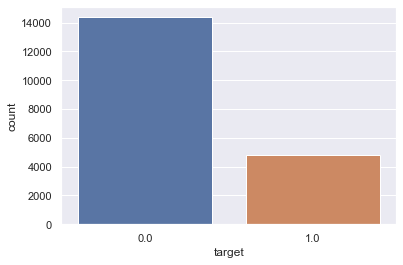

In [61]:
sns.countplot(df['target'], data=df)

In [61]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state = 42)
Xsmote, Ysmote = smote.fit_resample(X,Y)

#### Train Test Splitting

In [63]:
from sklearn.model_selection import train_test_split

In [64]:
xtrain, xtest, ytrain, ytest = train_test_split(Xsmote, Ysmote, test_size=0.3, random_state=100)
print(xtrain.shape, ytrain.shape)
print(xtest.shape, ytest.shape)

(20133, 12) (20133,)
(8629, 12) (8629,)


## Logistic Regression

In [129]:
from sklearn.linear_model import LogisticRegression

In [130]:
lr_model = LogisticRegression(random_state=25)

In [131]:
lr_model.fit(xtrain, ytrain)

F:\Anaconda3_1\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(random_state=25)

In [132]:
pred = lr_model.predict(xtest)

In [133]:
lr_pred_prb = lr_model.predict_proba(xtest)[:, 1]

In [134]:
accuracy_lr = accuracy_score(ytest, pred)
print("Accuracy by built-in function: {}".format(accuracy_lr))

Accuracy by built-in function: 0.6937072661953877


In [135]:
precision_lr = precision_score(ytest, pred)
print("Precision by built-in function: {}".format(precision_lr))

Precision by built-in function: 0.7191799298624224


In [136]:
recall_lr = recall_score(ytest, pred)
print("Recall by built-in function: {}".format(recall_lr))

Recall by built-in function: 0.6246485473289597


In [137]:
f1_lr = f1_score(ytest, pred)
print("F1 Score by built-in function: {}".format(f1_lr))

F1 Score by built-in function: 0.6685893416927899


In [138]:
print(classification_report(ytest, pred))


              precision    recall  f1-score   support

         0.0       0.67      0.76      0.72      4361
         1.0       0.72      0.62      0.67      4268

    accuracy                           0.69      8629
   macro avg       0.70      0.69      0.69      8629
weighted avg       0.70      0.69      0.69      8629



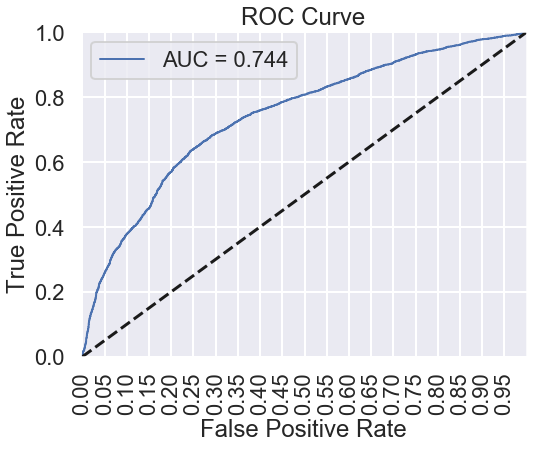

In [140]:
from sklearn.metrics import auc, roc_curve, roc_auc_score

def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(8, 6))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0, 1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc='best')

fpr, tpr, threshold = roc_curve(ytest, lr_pred_prb)

auc_lr = roc_auc_score(ytest, lr_pred_prb)
auc_lr
sns.set_context('poster')
plot_roc_curve(fpr, tpr, label='AUC = %0.3f' % auc_lr)

## Decision Tree

In [141]:
from sklearn.tree import DecisionTreeClassifier

clf_dt = DecisionTreeClassifier(
    max_depth=3, criterion='gini', random_state=100)

clf_dt.fit(xtrain, ytrain)

dt_pred = clf_dt.predict(xtest)
dt_pred_prb = clf_dt.predict_proba(xtest)[:, 1]

In [142]:
from sklearn.metrics import accuracy_score
# Accuracy score for Decision Tree
accuracy_dt = accuracy_score(ytest,dt_pred)
print("Accuracy: {}".format(accuracy_dt))

Accuracy: 0.7493336423687565


In [143]:
# Percision for Decision Tree
precision_dt=precision_score(ytest,dt_pred)
print("Precision: {}".format(precision_dt))

Precision: 0.7747324458365962


In [144]:
# Recall for Decision Tree

recall_dt = recall_score(ytest,dt_pred)
print("Recall: {}".format(recall_dt))

Recall: 0.6954076850984068


In [145]:
# F1 Score for Decision Tree

dt_f1=f1_score(ytest,dt_pred)
print("F1 Score: {}".format(dt_f1))

F1 Score: 0.7329299913569576


In [146]:
from sklearn.metrics import classification_report
print(classification_report(ytest,dt_pred))

              precision    recall  f1-score   support

         0.0       0.73      0.80      0.76      4361
         1.0       0.77      0.70      0.73      4268

    accuracy                           0.75      8629
   macro avg       0.75      0.75      0.75      8629
weighted avg       0.75      0.75      0.75      8629



In [147]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(8,6))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc='best')

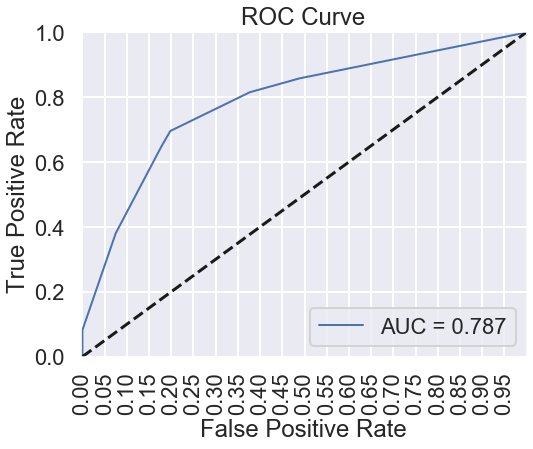

In [148]:
# ROC Curve for Decision Tree

from sklearn.metrics import auc, roc_curve, roc_auc_score

sns.set_context('poster')
auc_dt = roc_auc_score(ytest, dt_pred_prb)
fpr, tpr, threshold = roc_curve(ytest, dt_pred_prb)
plot_roc_curve(fpr, tpr, label='AUC = %0.3f' % auc_dt)

Text(0.5, 1.0, 'Decision Classifier - Features Importance')

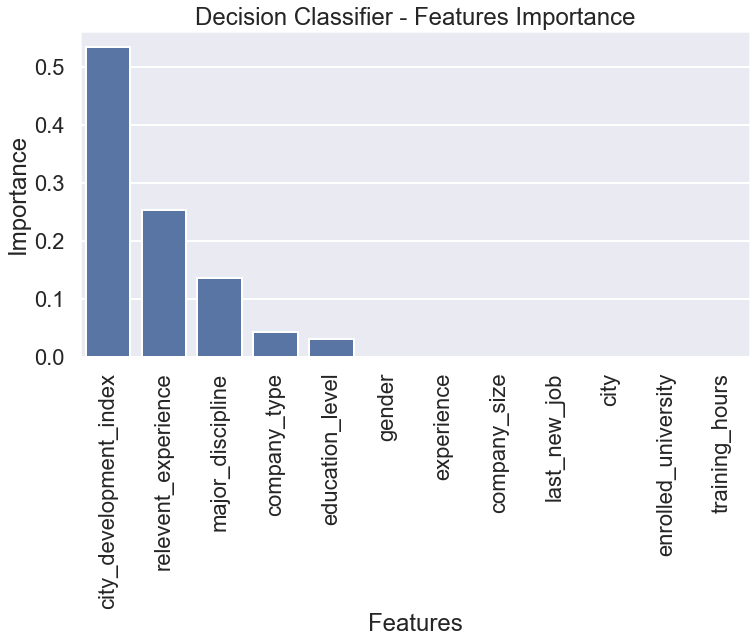

In [149]:
clf_dt.feature_importances_

features_tuple = list(zip(X.columns, clf_dt.feature_importances_))

features_tuple

feature_imp = pd.DataFrame(features_tuple, columns=[
                           "Feature Names", "Importance"])

feature_imp = feature_imp.sort_values("Importance", ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x="Feature Names", y="Importance", data=feature_imp, color='b')
plt.xlabel("Features")
plt.ylabel("Importance")
plt.xticks(rotation=90)
plt.title("Decision Classifier - Features Importance")

## Random Forest

In [150]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(random_state=100)

clf_rf.fit(xtrain, ytrain)

rf_pred = clf_rf.predict(xtest)
rf_pred_prb = clf_rf.predict_proba(xtest)[:, 1]

In [151]:
#precision_score for RandomForest
precision_rf=precision_score(ytest,rf_pred)
print("Precision: {}".format(precision_rf))

Precision: 0.8679817905918058


In [152]:
#Accuracy for RandomForest
accuracy_rf = accuracy_score(ytest,rf_pred)
print("Accuracy: {}".format(accuracy_rf))

Accuracy: 0.8426237107428439


In [153]:
#recall score for RandomForest
recall_rf = recall_score(ytest,rf_pred)
print("Recall: {}".format(recall_rf))

Recall: 0.8041237113402062


In [154]:
#F1-Score
rf_f1=f1_score(ytest,rf_pred)
print("F1 Score: {}".format(rf_f1))

F1 Score: 0.8348333738749695


In [155]:
#classification report for Random Forest
from sklearn.metrics import classification_report
print(classification_report(ytest,rf_pred))

              precision    recall  f1-score   support

         0.0       0.82      0.88      0.85      4361
         1.0       0.87      0.80      0.83      4268

    accuracy                           0.84      8629
   macro avg       0.84      0.84      0.84      8629
weighted avg       0.84      0.84      0.84      8629



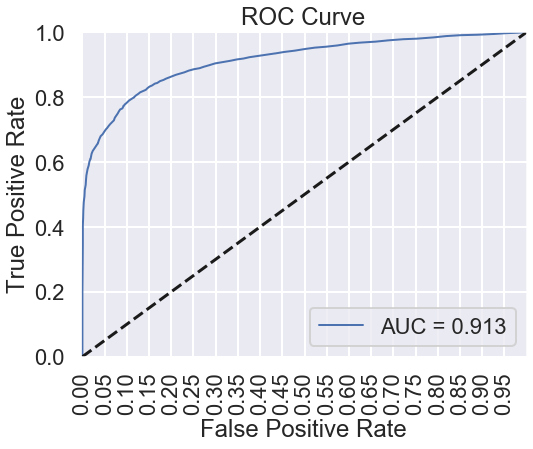

In [156]:
# ROC Curve for Random Forest
from sklearn.metrics import auc, roc_curve, roc_auc_score
auc_rf = roc_auc_score(ytest, rf_pred_prb)
fpr, tpr, threshold = roc_curve(ytest, rf_pred_prb)
plot_roc_curve(fpr, tpr, label='AUC = %0.3f' % auc_rf)

## Tuned Random Forest

### Hyperparameter Tuning using GridSearchCV

In [96]:
param_grid1 = {"n_estimators": [9, 18, 27, 36, 45, 54, 63],
               "max_depth": [1, 5, 10, 15, 20, 25, 30],
               "min_samples_leaf": [1, 2, 4, 6, 8, 10]}

RF = RandomForestClassifier(random_state=100)
# Instantiate the GridSearchCV object: logreg_cv
RF_cv1 = GridSearchCV(RF, param_grid1, cv=5, scoring='accuracy', n_jobs=4)

# Fit it to the data
RF_cv1.fit(xtrain, ytrain)

# RF_cv1.cv_results_,
RF_cv1.best_params_, RF_cv1.best_score_

({'max_depth': 30, 'min_samples_leaf': 2, 'n_estimators': 63},
 0.842546961018589)

In [97]:
param_grid2 = {"n_estimators": [59,60,61,62,63,64,65],
               "max_depth": [27,28,29,30,31,32],
               "min_samples_leaf": [1, 2, 3, 4]}

RF = RandomForestClassifier(random_state=100)
# Instantiate the GridSearchCV object: logreg_cv
RF_cv2 = GridSearchCV(RF, param_grid2, cv=5, scoring='accuracy', n_jobs=4)

# Fit it to the data
RF_cv2.fit(xtrain, ytrain)

# RF_cv2.grid_scores_,
RF_cv2.best_params_, RF_cv2.best_score_

({'max_depth': 32, 'min_samples_leaf': 2, 'n_estimators': 61},
 0.8438880453116328)

In [99]:
RF_grid = RF_cv2.best_estimator_

In [100]:
RF_grid.fit(xtrain, ytrain)

RandomForestClassifier(max_depth=32, min_samples_leaf=2, n_estimators=61,
                       random_state=100)

In [109]:
rf_pred_t = RF_grid.predict(xtest)
rf_pred_prb_t = RF_grid.predict_proba(xtest)[:, 1]

In [110]:
#Accuracy for Tuned Random Forest
accuracy_rf_t = accuracy_score(ytest,rf_pred_t)
print("Accuracy after tuning: {}".format(accuracy_rf_t))

Accuracy after tuning: 0.8443620349982617


In [111]:
#Recall for Tuned Random Forest
recall_rf_t=recall_score(ytest,rf_pred_t)
recall_rf_t

0.8064667291471416

In [112]:
#Precision for Tuned Random Forest
precision_rf_t=precision_score(ytest, rf_pred_t)
precision_rf_t

0.8694114675423087

In [113]:
#F1 Score
rf_t_f1=f1_score(ytest,rf_pred_t)
rf_t_f1

0.8367570195697095

In [114]:
#Classification Report for Tuned Random Forest

print(classification_report(ytest,rf_pred_t))

              precision    recall  f1-score   support

         0.0       0.82      0.88      0.85      4361
         1.0       0.87      0.81      0.84      4268

    accuracy                           0.84      8629
   macro avg       0.85      0.84      0.84      8629
weighted avg       0.85      0.84      0.84      8629



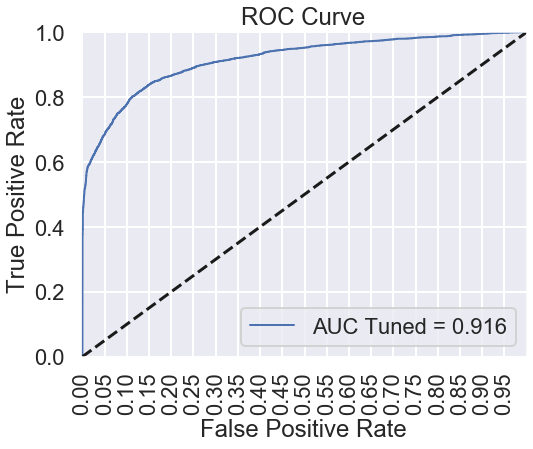

In [157]:
#ROC Curve for Tuned Random Forest
auc_rf_t = roc_auc_score(ytest, rf_pred_prb_t)
fpr, tpr, threshold = roc_curve(ytest, rf_pred_prb_t)
plot_roc_curve(fpr, tpr, label='AUC Tuned = %0.3f' % auc_rf_t)

### Hyperparameters Tuning Using Randomized Search

In [116]:
from sklearn.model_selection import RandomizedSearchCV

rf_rs = RandomForestClassifier(random_state=100)

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=10, stop=1000, num=10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

random_grid1 = {"n_estimators": n_estimators,
                "max_depth": max_depth,
                "min_samples_split": min_samples_split}

rf_random = RandomizedSearchCV(
    estimator=rf_rs, param_distributions=random_grid1, n_iter=50, cv=5, verbose=2, random_state=100)
# Fit the random search model
rf_random.fit(xtrain, ytrain)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END max_depth=80, min_samples_split=10, n_estimators=450; total time=   6.7s
[CV] END max_depth=80, min_samples_split=10, n_estimators=450; total time=   6.9s
[CV] END max_depth=80, min_samples_split=10, n_estimators=450; total time=   6.9s
[CV] END max_depth=80, min_samples_split=10, n_estimators=450; total time=   7.1s
[CV] END max_depth=80, min_samples_split=10, n_estimators=450; total time=   6.6s
[CV] END max_depth=30, min_samples_split=5, n_estimators=560; total time=   9.0s
[CV] END max_depth=30, min_samples_split=5, n_estimators=560; total time=   9.3s
[CV] END max_depth=30, min_samples_split=5, n_estimators=560; total time=   9.1s
[CV] END max_depth=30, min_samples_split=5, n_estimators=560; total time=   9.3s
[CV] END max_depth=30, min_samples_split=5, n_estimators=560; total time=   8.8s
[CV] END max_depth=None, min_samples_split=2, n_estimators=1000; total time=  17.2s
[CV] END max_depth=None, min_samples_sp

[CV] END max_depth=20, min_samples_split=10, n_estimators=670; total time=   9.8s
[CV] END max_depth=20, min_samples_split=10, n_estimators=670; total time=   9.9s
[CV] END max_depth=20, min_samples_split=10, n_estimators=670; total time=  10.0s
[CV] END max_depth=20, min_samples_split=10, n_estimators=670; total time=   9.8s
[CV] END max_depth=20, min_samples_split=10, n_estimators=670; total time=   9.8s
[CV] END max_depth=60, min_samples_split=5, n_estimators=340; total time=   5.6s
[CV] END max_depth=60, min_samples_split=5, n_estimators=340; total time=   5.3s
[CV] END max_depth=60, min_samples_split=5, n_estimators=340; total time=   6.0s
[CV] END max_depth=60, min_samples_split=5, n_estimators=340; total time=   5.6s
[CV] END max_depth=60, min_samples_split=5, n_estimators=340; total time=   5.5s
[CV] END max_depth=60, min_samples_split=5, n_estimators=120; total time=   1.9s
[CV] END max_depth=60, min_samples_split=5, n_estimators=120; total time=   1.9s
[CV] END max_depth=60, 

[CV] END max_depth=30, min_samples_split=2, n_estimators=450; total time=  11.6s
[CV] END max_depth=30, min_samples_split=2, n_estimators=450; total time=   8.0s
[CV] END max_depth=30, min_samples_split=2, n_estimators=450; total time=   7.3s
[CV] END max_depth=30, min_samples_split=2, n_estimators=450; total time=   7.3s
[CV] END max_depth=None, min_samples_split=5, n_estimators=560; total time=   8.8s
[CV] END max_depth=None, min_samples_split=5, n_estimators=560; total time=   8.5s
[CV] END max_depth=None, min_samples_split=5, n_estimators=560; total time=   8.5s
[CV] END max_depth=None, min_samples_split=5, n_estimators=560; total time=   8.5s
[CV] END max_depth=None, min_samples_split=5, n_estimators=560; total time=   8.5s
[CV] END max_depth=80, min_samples_split=5, n_estimators=1000; total time=  15.2s
[CV] END max_depth=80, min_samples_split=5, n_estimators=1000; total time=  15.3s
[CV] END max_depth=80, min_samples_split=5, n_estimators=1000; total time=  15.2s
[CV] END max_de

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=100),
                   n_iter=50,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 120, 230, 340, 450,
                                                         560, 670, 780, 890,
                                                         1000]},
                   random_state=100, verbose=2)

In [117]:
clf_rf_rand = rf_random.best_estimator_

clf_rf_rand.fit(xtrain, ytrain)

pred_rf_rand = clf_rf_rand.predict(xtest)

prb_rf_rand = clf_rf_rand.predict_proba(xtest)[:, 1]

In [118]:
#Accuracy of Tuned Random Forest through Randomized Search
accuracy_rf_r= accuracy_score(ytest,pred_rf_rand)
accuracy_rf_r

0.8455209178352069

In [119]:
#Precision of Tuned Random Forest through Randomized Search

precision_rf_r=precision_score(ytest,pred_rf_rand)
precision_rf_r

0.8718013681276919

In [120]:
#Recall of Tuned Random Forest through Randomized Search
recall_rf_r=recall_score(ytest,pred_rf_rand)
recall_rf_r

0.806232427366448

In [121]:
#F1-Score of Tuned Random Forest through Randomized Search
f1_rf_r=f1_score(ytest,pred_rf_rand)
f1_rf_r

0.8377358490566037

In [122]:
#Classification Report of Tuned Random Forest through Randomized Search
print(classification_report(ytest,pred_rf_rand))

              precision    recall  f1-score   support

         0.0       0.82      0.88      0.85      4361
         1.0       0.87      0.81      0.84      4268

    accuracy                           0.85      8629
   macro avg       0.85      0.85      0.85      8629
weighted avg       0.85      0.85      0.85      8629



In [128]:
# ROC Curve
auc_rf_r = roc_auc_score(ytest, prb_rf_rand)
fpr, tpr, threshold = roc_curve(ytest, prb_rf_rand)
auc_rf_r

0.9176261613814358

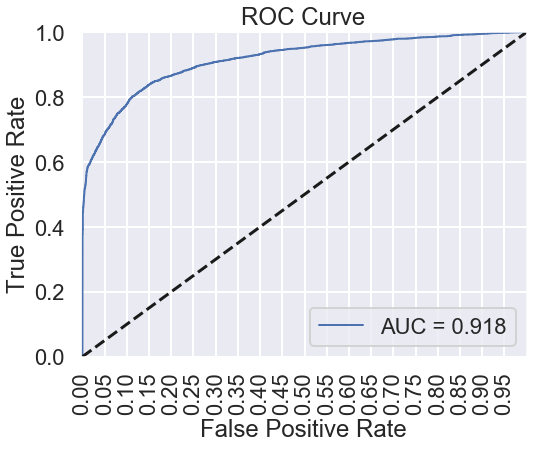

In [158]:
plot_roc_curve(fpr, tpr, label='AUC = %0.3f' % auc_rf_r)

## Ada Boost

In [80]:
from sklearn.ensemble import AdaBoostClassifier

clf_adb = AdaBoostClassifier(random_state=100)
clf_adb.fit(xtrain, ytrain)

pred_clf_adb = clf_adb.predict(xtest)

adb_pred_prb = clf_adb.predict_proba(xtest)[:, 1]

In [81]:
# Accuracy for Ada Boost
accuracy_adb=accuracy_score(ytest,pred_clf_adb)
accuracy_adb

0.8295283346853634

In [82]:
# Percision for Ada Boost
precision_adb=precision_score(ytest, pred_clf_adb)
precision_adb

0.8596040113139625

In [83]:
#Recall for Ada Boost
recall_adb=recall_score(ytest,pred_clf_adb)
recall_adb

0.7832708528584817

In [84]:
#F1-Score for Ada Boost
f1_adb=f1_score(ytest, pred_clf_adb)
f1_adb

0.8196640921907564

In [85]:
# Classfication Report
print(classification_report(ytest,pred_clf_adb))

              precision    recall  f1-score   support

         0.0       0.80      0.87      0.84      4361
         1.0       0.86      0.78      0.82      4268

    accuracy                           0.83      8629
   macro avg       0.83      0.83      0.83      8629
weighted avg       0.83      0.83      0.83      8629



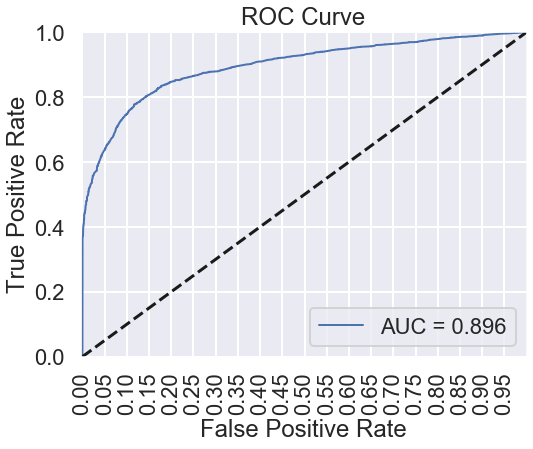

In [86]:
# ROC Curve for Ada Boost
auc_adb = roc_auc_score(ytest, adb_pred_prb)
fpr, tpr, threshold = roc_curve(ytest, adb_pred_prb)
plot_roc_curve(fpr, tpr, label='AUC = %0.3f' % auc_adb)

## XBGClassifier

In [65]:
clf_xgb = XGBClassifier()

clf_xgb.fit(xtrain, ytrain)

pred_clf_xgb = clf_xgb.predict(xtest)
xgb_pred_prb = clf_xgb.predict_proba(xtest)[:, 1]
# Accuracy for XGBoost
accuracy_xgb = accuracy_score(ytest, pred_clf_xgb)
accuracy_xgb

0.8410012747711206

In [66]:
# Percision for XGBoost
precision_xgb = precision_score(ytest, pred_clf_xgb)
precision_xgb

0.8652875882946519

In [67]:
#Recall for XGBoost
recall_xgb = recall_score(ytest, pred_clf_xgb)
recall_xgb

0.8036551077788191

In [160]:
# F1-Score for XGBoost
xgb_f1=f1_score(ytest, pred_clf_xgb)
xgb_f1

0.8333333333333334

In [77]:
# Classification Report for XGBoost
print(classification_report(ytest,pred_clf_xgb))

              precision    recall  f1-score   support

         0.0       0.82      0.88      0.85      4361
         1.0       0.87      0.80      0.83      4268

    accuracy                           0.84      8629
   macro avg       0.84      0.84      0.84      8629
weighted avg       0.84      0.84      0.84      8629



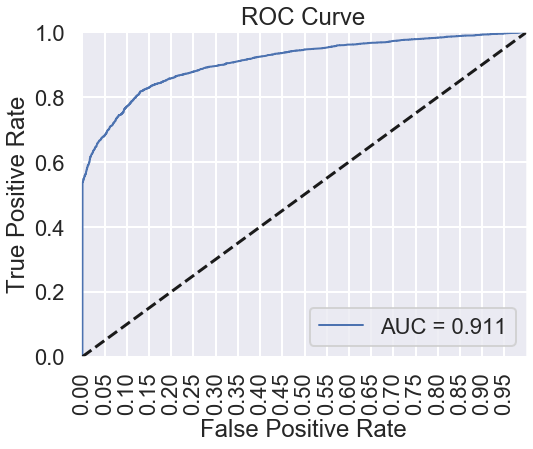

In [78]:
# ROC Curve for XGBoost
auc_xgb = roc_auc_score(ytest, xgb_pred_prb)
fpr, tpr, threshold = roc_curve(ytest, xgb_pred_prb)
plot_roc_curve(fpr, tpr, label='AUC = %0.3f' % auc_xgb)

## Comparison

In [161]:
comparison_dict={"Algorithm":["Decision Tree","Random Forest","Tuned Random Forest(Grid)","Tuned Random Forest(Random)","XGBoost","Ada Boost"],
                 "Accuracy":[accuracy_dt,accuracy_rf,accuracy_rf_t,accuracy_rf_r,accuracy_xgb,accuracy_adb],
                 "Precision":[precision_dt,precision_rf,precision_rf_t,precision_rf_r,precision_xgb,precision_adb],
                 "Recall":[recall_dt,recall_rf,recall_rf_t,recall_rf_r,recall_xgb,recall_adb],
                 "AUC":[auc_dt,auc_rf,auc_rf_t,auc_rf_r,auc_xgb,auc_adb],
                 "F1 Score":[dt_f1,rf_f1,rf_t_f1,f1_rf_r,xgb_f1,f1_adb]
                }

In [162]:
comparison = pd.DataFrame(comparison_dict)
comparison.sort_values(['Recall', 'Accuracy', 'AUC'], ascending=False)

,Algorithm,Accuracy,Precision,Recall,AUC,F1 Score
2,Tuned Random Forest(Grid),0.844362,0.869411,0.806467,0.916146,0.836757
3,Tuned Random Forest(Random),0.845521,0.871801,0.806232,0.917626,0.837736
1,Random Forest,0.842624,0.867982,0.804124,0.913441,0.834833
4,XGBoost,0.841001,0.865288,0.803655,0.910754,0.833333
5,Ada Boost,0.829528,0.859604,0.783271,0.895552,0.819664
0,Decision Tree,0.749334,0.774732,0.695408,0.786982,0.732930


From the abvoe comparison it is clear that "Tuned Random Forest" performs the best and we can choose it over remaining algorithms for perdiction purposes.

## <center><span style="color:black"> The End </span></center>